In [1]:
import numpy as np
from scipy import interpolate
from matplotlib.tri import Triangulation
import matplotlib.pyplot as plt
# These are just cosmetics
plt.style.use('seaborn-white')
#plt.style.use('ggplot')
plt.rc('font', size=16) #controls default text size
plt.rc('axes', titlesize=16) #fontsize of the title
plt.rc('axes', labelsize=16) #fontsize of the x and y labels
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend

In [2]:
import V2RhoT_gibbs_lib as lib

In [3]:
DMM_no_atten = np.loadtxt('./databases/DMM_HP',comments='#')
# correction using grain size = 10 mm and oscillatio period of 75 seconds.
# Attenuation model of Jackson and Faul 2010
# Function: lib.atten_correction (T (oC),P (Pascal),Vp (km/s),Vs (km/s),oscilation period (s), grain size (mm))
DMM_atten_corrected = np.copy(DMM_no_atten)
for i in range(len(DMM_atten_corrected)):
    DMM_atten_corrected[i,3],DMM_atten_corrected[i,4] = lib.atten_correction(DMM_atten_corrected[i,0],DMM_atten_corrected[i,1]*1e5,
                                                         DMM_atten_corrected[i,3],DMM_atten_corrected[i,4],75,10)

# correction for melts
# These are relations from lab experiments. More details in Afonso et al., 2016 III
# Function: lib.velocity_melt_correction_mantle (T (oC),P (GPa),VP (km/s),Vs (km/s)
DMM_atten_melt_corrected = np.copy(DMM_atten_corrected)
melt = np.zeros_like(DMM_atten_melt_corrected[:,0])
for i in range(len(DMM_atten_melt_corrected)):
    DMM_atten_melt_corrected[i,3],DMM_atten_melt_corrected[i,4],melt[i] = lib.velocity_melt_correction_mantle(DMM_atten_melt_corrected[i,0]-273.15,
                                                                                             DMM_atten_melt_corrected[i,1]/1e4,
                                                             DMM_atten_melt_corrected[i,3],DMM_atten_melt_corrected[i,4])
# append melt to the table 
DMM_atten_melt_corrected[:,5]=melt[:]
Composition_1 =DMM_atten_melt_corrected

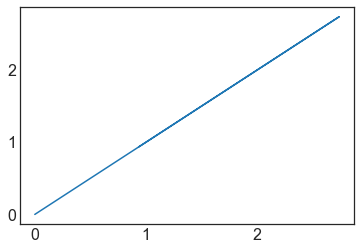

In [4]:
plt.plot(melt,DMM_atten_melt_corrected[:,5])

In [5]:
np.shape(temp)

NameError: name 'temp' is not defined

In [6]:
### lithostatic pressure 
def lithostatic_pressure(depth,density):
    Pressure_lith = np.zeros_like(depth)
    # Check is the first index is at zero depth or not
    # If it is not then pressures is set equal rho*g*h
    # else is it set to 0
    if depth[0] != 0:
        Pressure_lith[0] = density[0] * depth[0]* 9.8 * 1e3 * 1e-5
    else:
        #thickness = (depth[1]-depth[0]) #*1e3
        Pressure_lith[0] = 0
    # Now looping through depths
    for j in range(len(depth)-2):
        thickness = (depth[j+2] - depth [j+1]) *1e3
        Pressure_lith[j+1]=Pressure_lith[j] + thickness*density[j+1] *9.8*1e-5
        
    # fixing last index
    Pressure_lith[-1] = Pressure_lith[-2] + (depth[-1] - depth [-2])*1e3 * density[-2]*9.8*1e-5 
    #print(depth[:],density[:],Pressure_lith[:])

    p_func = interpolate.interp1d(depth,Pressure_lith)
    return p_func


In [7]:
### lithostatic pressure 
def lithostatic_pressure_depth(depth,density):
    Pressure = 0
    # Check is the first index is at zero depth or not
    # If it is not then pressures is set equal rho*g*h
    # else is it set to 0
    if np.size(depth) > 1:
        Pressure_lith = np.zeros_like(depth)
        if depth[0] != 0:
            Pressure_lith[0] = density[0] * depth[0]* 9.8 * 1e3 * 1e-5
        else:
            #thickness = (depth[1]-depth[0]) #*1e3
            Pressure_lith[0] = 0
            # Now looping through depths
        for j in range(len(depth)-2):
            thickness = (depth[j+2] - depth [j+1]) *1e3
            Pressure_lith[j+1]=Pressure_lith[j] + thickness*density[j+1] *9.8*1e-5
        Pressure = Pressure_lith[-1]
    elif depth !=0:
        Pressure = (depth-0)*density* 9.8 * 1e3 * 1e-5
    else:
        Pressure = 0
    #print(Pressure)
    return Pressure

In [8]:
tomo_NA_stack=np.loadtxt('./data_tomo/NA_age_vel_stack.dat',comments='#')
# Just formating the data required
data=tomo_NA_stack[:,0];
data=np.column_stack((data,tomo_NA_stack[:,0]))
data=np.column_stack((data,tomo_NA_stack[:,1]))
data=np.column_stack((data,tomo_NA_stack[:,2]))
data[:,1]=0
X = np.unique(data[:,0])
Y = np.unique(data[:,1])
Z = np.unique(data[:,2])
nx,ny,nz = np.meshgrid(X,Y,Z)
V= np.zeros_like(nz)
Composition = np.zeros_like(nz)+1 

In [9]:
m,n,p = np.shape(nz)
for i in range(m):
    for j in range(n):
        for k in range(p):
            ind = np.where( (data[:,0] == nx[i][j][k]) & (data[:,1] == ny[i][j][k]) & (data[:,2] == nz[i][j][k]))
            #print(nx[i][j][k],ny[i][j][k],nz[i][j][k])
            try:
                V[i][j][k] = data[ind[0],3]
            except:
                print('Data is not a 3D volume!!')

In [10]:
def vel_to_temp_P_loop(nx,ny,nz,Vs,Table):
    Temperature_out = np.zeros_like(nx)
    Density_out     = np.zeros_like(nx) #+3300
    diff_Vs         = np.zeros_like(nx)
    P_out           = np.zeros_like(nx)
    melt_out        = np.zeros_like(nx)
    Vp_out          = np.zeros_like(nx)#np.zeros_like(tomo[:,1])
    Vs_out          = np.zeros_like(nx)#np.zeros_like(tomo[:,1])
    m,n,p=np.shape(nx)
    # looping over all the geospatial nodes
    for i in range(m):
        for j in range(n):
            #P_func=lithostatic_pressure(nz[i][j][:],Density_out[i][j][:])
            # Starting with ak135 pressure profile
            P_func=lib.pressure_inter
            # setting positive difference to set the while loop
            diff = 10
            p_counter  = 0
            while diff > 0:
                #print(f'{p_counter} Pressure counter {threshhold}.')
                p_counter = p_counter+1
                # loop over all depths to get the density and temperature
                for k in range(p):
                    P  = P_func(nz[i][j][k])
                    Vs_in = Vs[i][j][k]
                    P_table,temp,dens,vp,vs,melt=lib.lookup_vs_P_accurate_prop(Vs_in,P.tolist(),Table)
                    P_out[i][j][k] = P_table 
                    Temperature_out[i][j][k]=temp
                    Density_out[i][j][k]=dens
                    Vs_out[i][j][k]=vs
                    Vp_out[i][j][k]=vp
                    melt_out[i][j][k]=melt
                # calulcating new pressure profile
                P_func_new=lithostatic_pressure(nz[i][j][:],Density_out[i][j][:])
                # RMS difference between initial and updated pressure profile
                diff = np.sqrt(((P_func_new(nz[i][j][:]) - P_func(nz[i][j][:])) ** 2).mean())
                print(diff)
                # update the pressure profile
                P_func = P_func_new
    return P_out,Temperature_out,Density_out,Vp_out,Vs_out,melt_out 

def vel_to_temp(nx,ny,nz,Vs,Table):
    Temperature_out = np.zeros_like(nx)
    Density_out     = np.zeros_like(nx)#+3300
    diff_Vs         = np.zeros_like(nx)
    P_out           = np.zeros_like(nx)
    melt_out        = np.zeros_like(nx)
    Vp_out          = np.zeros_like(nx)#np.zeros_like(tomo[:,1])
    Vs_out          = np.zeros_like(nx)#np.zeros_like(tomo[:,1])
    m,n,p=np.shape(nx)
    # looping over all the geospatial nodes
    for i in range(m):
        for j in range(n):
            P_func=lib.pressure_inter
            for k in range(p):
                P  = P_func(nz[i][j][k])
                Vs_in = Vs[i][j][k]
                P_table,temp,dens,vp,vs,melt=lib.lookup_vs_P_accurate_prop(Vs_in,P.tolist(),Table)
                P_out[i][j][k] = P_table 
                Temperature_out[i][j][k]=temp
                Density_out[i][j][k]=dens
                Vs_out[i][j][k]=vs
                Vp_out[i][j][k]=vp
                melt_out[i][j][k]=melt
    return P_out,Temperature_out,Density_out,Vp_out,Vs_out,melt_out 

In [ ]:
def vel_to_temp_P_loop(nx,ny,nz,Vs,Table):
    Temperature_out = np.zeros_like(nx)
    Density_out     = np.zeros_like(nx)
    diff_Vs         = np.zeros_like(nx)
    P_out           = lib.pressure_inter(nz) #np.zeros_like(nx)
    melt_out        = np.zeros_like(nx)
    Vp_out          = np.zeros_like(nx)#np.zeros_like(tomo[:,1])
    Vs_out          = np.zeros_like(nx)#np.zeros_like(tomo[:,1])
    m,n,p=np.shape(nx)
    # looping over all the geospatial nodes
    for i in range(m):
        for j in range(n):
            P_func=lithostatic_pressure(nz[i][j][:],Density_out[i][j][:])
            # Starting with ak135 pressure profile
            #P_func=lib.pressure_inter
            # setting positive difference to set the while loop
                #print(f'{p_counter} Pressure counter {threshhold}.')
                # loop over all depths to get the density and temperature
                #P_new=np.zeros_like(nz[i][j][:])
            for k in range(p):
                    Vs_in = Vs[i][j][k]
                    #  = P_func(nz[i][j][k])
                    diff = 100
                    p_counter  = 0
                    #P =lib.pressure_inter(nz[i][j][k])
                    while  diff > 0:
                        #P =  (nz[i][j][k]-0)*Density_out[i][j][k]* 9.8 * 1e3 * 1e-5
                        if k==0:
                            P =   lithostatic_pressure_depth(nz[i][j][0],Density_out[i][j][0])
                        else:
                            P =   lithostatic_pressure_depth(nz[i][j][0:k],Density_out[i][j][0:k])
                        
                        P_table,temp,dens,vp,vs,melt=lib.lookup_vs_P_accurate_prop(Vs_in,P,Table)
                        Density_out[i][j][k]=dens
                        if k==0:
                            P_new =   lithostatic_pressure_depth(nz[i][j][0],Density_out[i][j][0])
                        else:
                            P_new =   lithostatic_pressure_depth(nz[i][j][0:k],Density_out[i][j][0:k])
                        #P_new=P_table
                        
                        #if k==0:
                        #    P_new =   (nz[i][j][k]-0)*Density_out[i][j][k]* 9.8 * 1e3 * 1e-5 #lithostatic_pressure_depth(nz[i][j][0],Density_out[i][j][0])
                        #else:
                        #    P_new =   (nz[i][j][k]-0)*Density_out[i][j][k]* 9.8 * 1e3 * 1e-5 #lithostatic_pressure_depth(nz[i][j][0:k],Density_out[i][j][0:k])
                        #P_new=P_table
                        diff = abs(P_new-P)
                        p_counter = p_counter+1
                        print('Depth is',nz[i][j][k])
                        print(f'{p_counter} Pressure updated {diff}.')
                        P = P_new
                        P_out[i][j][k] = P 
                    Temperature_out[i][j][k]=temp
                    Vs_out[i][j][k]=vs
                    Vp_out[i][j][k]=vp
                    melt_out[i][j][k]=melt
                # calulcating new pressure profile
                #P_func_new=lithostatic_pressure(nz[i][j][:],Density_out[i][j][:])
                #P_func_new = interpolate.interp1d(nz[i][j][:],P_new[:])
                # RMS difference between initial and updated pressure profile
                #diff = np.sqrt(((P_func_new(nz[i][j][:]) - P_func(nz[i][j][:])) ** 2).mean())
                #print(f'{p_counter} Pressure updated {diff}.')
                # update the pressure profile
                #P_func = P_func_new
    return P_out,Temperature_out,Density_out,Vp_out,Vs_out,melt_out 


In [11]:
P_P_loop,T_P_loop,D_P_loop,Vp_P_loop,Vs_P_loop,melt_P_loop=vel_to_temp_P_loop(nx,ny,nz,V,Composition_1)


1959.565653349907
95.99526017517351
3.9277045882507835
0.4694835473696602
0.0
1940.9655986326054
95.43357926669529
4.0336172688589045
0.0
1908.9708088794948
91.2337609685515
3.937343035685562
0.0
1891.2888403791449
88.34598296981652
3.9744583006073038
0.7145497558873768
0.0
1862.319207616127
87.37915901796953
2.6806848843829076
0.0
1831.2023691853567
91.46315021377639
3.5003465294379628
0.0
1775.6489597314837
84.54822148888336
2.8998249834133234
0.0
1721.8302609284215
79.86289256820953
2.2419744884166226
0.0
1685.1686154743552
77.34804341523285
2.262701011653732
0.0
1647.6213468501728
73.56188763114116
4.968796649987545
0.132300000001851
0.0
1610.812185877481
69.91049675277185
2.436993198804636
0.3229538897512945
0.0
1540.4353122519467
71.21892576737113
1.9534711306753094
0.0
1490.0539657075844
66.54699424490539
1.4041901741935956
0.0
1403.487806596603
58.53285846912101
3.576557441362685
0.0
1389.4503457597789
59.713683431320106
0.7859260520931272
0.0
1375.6601795397955
51.998675629818

In [12]:
P,T,D,Vp,Vs,melt=vel_to_temp(nx,ny,nz,V,DMM_atten_melt_corrected)

Text(0.5, 1.0, 'P loop')

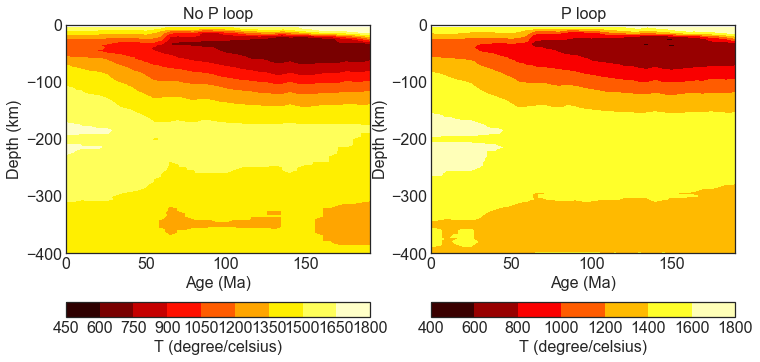

In [13]:
tri = Triangulation(nx.flatten(),-nz.flatten())
fig, ax = plt.subplots(1, 2,sharex=False, sharey=False,figsize=(12,6))
T_gibbs = ax[0].tricontourf(tri, T.flatten(),cmap='hot')#,levels=np.arange(200,1500,100))
T_gibbs_P = ax[1].tricontourf(tri, T_P_loop.flatten(),cmap='hot')#,levels=np.arange(200,1500,100))
for a in ax:
        #a.set_aspect('equal')
        a.set_ylim([-400,0])
        a.set_xlabel('Age (Ma)')
        a.set_ylabel('Depth (km)')
        a.set_title('')
fig.colorbar(T_gibbs, ax=ax[0], label='T (degree/celsius)', orientation='horizontal')
fig.colorbar(T_gibbs_P, ax=ax[1], label='T (degree/celsius)', orientation='horizontal')
ax[0].set_title('No P loop')
ax[1].set_title('P loop')

#fig.colorbar(m_t_out, ax=ax[2], label='Temperature (Celcius)', orientation='horizontal')
#fig.colorbar(m_dens_out, ax=ax[3], label='Density (g/cm3)', orientation='horizontal')
#fig.suptitle(title, fontsize=16)
#ax.set_ylim([-400,0])
#ax.set_xlabel('Distance (km)')
#ax.set_ylabel('Depth (km)')
#fig.colorbar(m_v_in_gibbs, ax=ax[0], label='Temperature (degree/celcius)', orientation='vertical')

Text(0.5, 1.0, 'P loop')

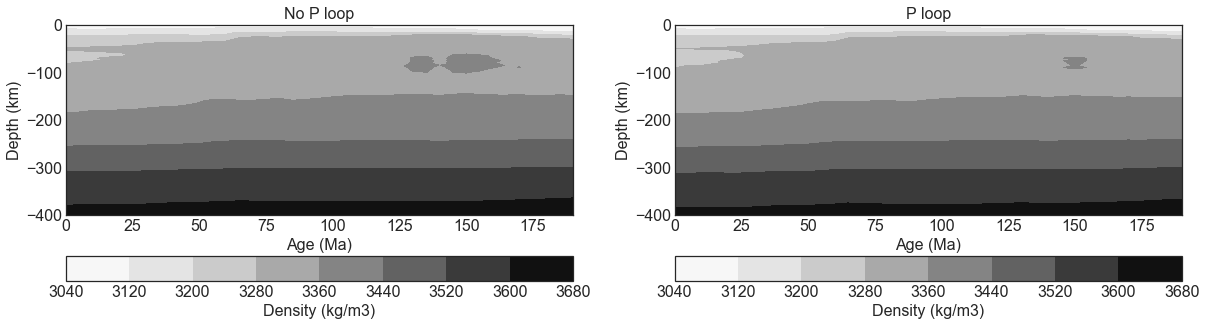

In [14]:
tri = Triangulation(nx.flatten(),-nz.flatten())
fig, ax = plt.subplots(1, 2,sharex=False, sharey=False,figsize=(20,5))
D_gibbs = ax[0].tricontourf(tri, D.flatten())
D_gibbs_P = ax[1].tricontourf(tri, D_P_loop.flatten())
for a in ax:
        #a.set_aspect('equal')
        a.set_ylim([-400,0])
        a.set_xlabel('Age (Ma)')
        a.set_ylabel('Depth (km)')
        a.set_title('')
fig.colorbar(D_gibbs, ax=ax[0], label='Density (kg/m3)', orientation='horizontal')
fig.colorbar(D_gibbs_P, ax=ax[1], label='Density (kg/m3)', orientation='horizontal')
ax[0].set_title('No P loop')
ax[1].set_title('P loop')

Text(0.5, 1.0, 'P loop')

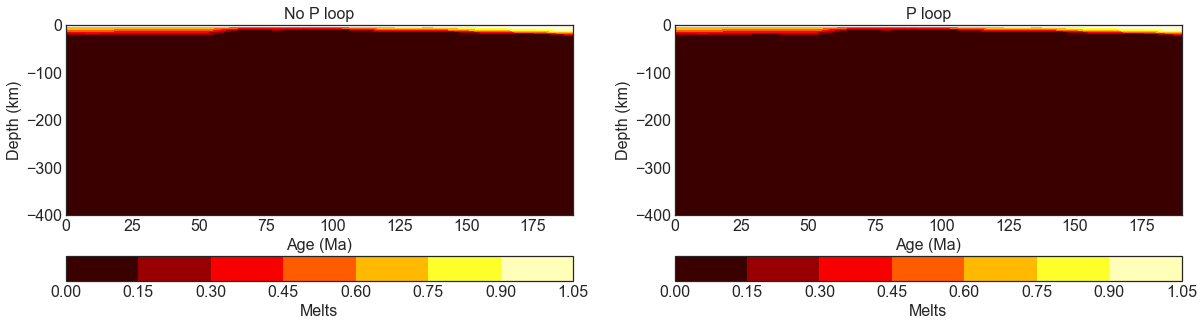

In [15]:
tri = Triangulation(nx.flatten(),-nz.flatten())
fig, ax = plt.subplots(1, 2,sharex=False, sharey=False,figsize=(20,5))
D_gibbs   = ax[0].tricontourf(tri, melt.flatten(),cmap='hot')#,levels=np.arange(0,2,0.2))
D_gibbs_P = ax[1].tricontourf(tri, melt_P_loop.flatten(),cmap='hot')#,levels=np.arange(0,2,0.2))
for a in ax:
        #a.set_aspect('equal')
        a.set_ylim([-400,0])
        a.set_xlabel('Age (Ma)')
        a.set_ylabel('Depth (km)')
        a.set_title('')
fig.colorbar(D_gibbs, ax=ax[0], label='Melts', orientation='horizontal')
fig.colorbar(D_gibbs_P, ax=ax[1], label='Melts', orientation='horizontal')
ax[0].set_title('No P loop')
ax[1].set_title('P loop')

In [16]:
T_mantle = 1350 # oC
alpha    = 3e-5 # oC-1
cp       = 1250 # J/kg/oC 
g        = 9.8 #m/s2
dT_dZ    = ((T_mantle*alpha*g)/cp)*1e3 # oC/km
print('Adiabatic gradient (/km):',dT_dZ)
#T = T_mantle + Z*dT_dZ

Adiabatic gradient (/km): 0.31752


In [19]:
m,n,p=np.shape(nx)
Thermal_boundary = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        T_mantle    = 1200 #T_P_loop[i][j][-1] #1600 # oC
        #T_mantle    = T_P_loop[i][j][-1] #1600 # oC
        #print(T_mantle)
        alpha       = 3e-5 # oC-1
        cp          = 1250 # J/kg/oC 
        g           = 9.8 #m/s2
        dT_dZ       = ((T_mantle*alpha*g)/cp)*1e3 # oC/km
        adiabat     = T_mantle + nz[i][j][:]*dT_dZ
        temperature = T_P_loop[i][j][:]
        dist        = np.array((adiabat-temperature)**2);
        index       = dist.argmin()
        Thermal_boundary[i][j]=nz[i][j][index]


Text(0.5, 0, 'Age (Ma)')

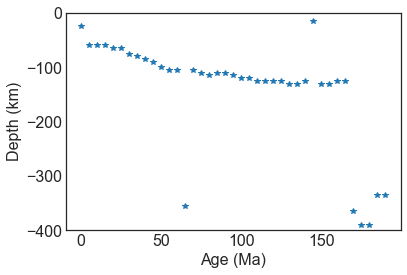

In [20]:
plt.plot(X,-Thermal_boundary.flatten(),'*')
plt.ylim([-400,0])
plt.ylabel('Depth (km)')
plt.xlabel('Age (Ma)')

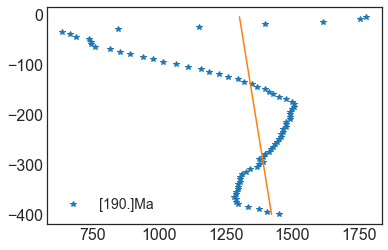

In [26]:
index=38
T_mantle    = 1300 # oC
#T_mantle    = T_P_loop[0][index][-1]
alpha       = 3e-5 # oC-1
cp          = 1250 # J/kg/oC 
g           = 9.8 #m/s2
dT_dZ       = ((T_mantle*alpha*g)/cp)*1e3 # oC/km
        
plt.plot(T[0][index][:],-nz[0][index][:],'*',label=str(np.unique(nx[0][index][:]))+'Ma')
plt.plot(T_mantle + nz[0][index][:]*dT_dZ,-nz[0][index][:])
#plt.plot(T_mantle + nz[0][index][:]*dT_dZ,-nz[0][index][:],'*')

#plt.ylim([-400,0])
plt.legend()

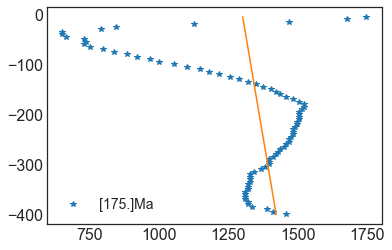

In [27]:
index=35
T_mantle    = 1300 # oC
#T_mantle    = T_P_loop[0][index][-1]
alpha       = 3e-5 # oC-1
cp          = 1250 # J/kg/oC 
g           = 9.8 #m/s2
dT_dZ       = ((T_mantle*alpha*g)/cp)*1e3 # oC/km
        
plt.plot(T[0][index][:],-nz[0][index][:],'*',label=str(np.unique(nx[0][index][:]))+'Ma')
plt.plot(T_mantle + nz[0][index][:]*dT_dZ,-nz[0][index][:])
#plt.plot(T_mantle + nz[0][index][:]*dT_dZ,-nz[0][index][:],'*')

#plt.ylim([-400,0])
plt.legend()